In [1]:
from sdo.sood.data.sdo_ml_v2_dataset import SDOMLv2DataModule, SDOMLv2NumpyDataset

In [2]:
from pathlib import Path
import numpy as np
import os 
import sunpy
from sunpy.visualization.colormaps import cm
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import torchvision
import torch
import torchvision.transforms.functional as F

#inspect an image

#Channels that correspond to HMI Magnetograms 
HMI_WL = ['Bx','By','Bz']
#A colormap for visualizing HMI
HMI_CM = LinearSegmentedColormap.from_list("bwrblack", ["#0000ff","#000000","#ff0000"])

def channel_to_map(name):
    """Given channel name, return colormap"""
    return HMI_CM if name in HMI_WL else cm.cmlist.get('sdoaia%d' % int(name))

def get_clip(X, name):
    """Given an image and the channel name, get the right clip"""
    return get_signed_pct_clip(X) if name in HMI_WL else get_pct_clip(X)

def get_pct_clip(X):
    """Return the 99.99th percentile"""
    return (0,np.quantile(X.ravel(),0.999))

def get_signed_pct_clip(X):
    """Return the 99.99th percentile by magnitude, but symmetrize it so 0 is in the middle"""
    v = np.quantile(np.abs(X.ravel()),0.999)
    return (-v,v)

def vis(X, cm, clip=None):
    """Given image, colormap, and a clipping, visualize results"""
    Xc = X
    if clip:
        Xc = np.clip((X-clip[0])/(clip[1]-clip[0]),0,1)
    Xcv = cm(Xc)
    return (Xcv[:,:,:3]*255).astype(np.uint8)


#def vis(X, cm):
#    """Given image, colormap, and visualize results"""
#    Xcv = cm(X)
#    return (Xcv[:,:,:3]*255).astype(np.uint8)

def show_grid(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    nrows=int(len(imgs)/4)
    ncols=4
    if nrows <= 0:
        nrows = 1
        ncols = len(imgs)
    fix, axs = plt.subplots(figsize=(24,24), ncols=ncols, nrows=nrows, squeeze=False)
    row = 0
    for i, img in enumerate(imgs):
        col = i % 4
        if i != 0 and i % 4 == 0:
            row = row + 1
        axs[row, col].imshow(img)
        axs[row, col].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    plt.show()

In [3]:
loader = SDOMLv2DataModule("fdl-sdoml-v2/sdomlv2_small.zarr/", channel="171A", train_start="2010-08-27 00:00:00", train_end="2010-08-28 23:59:59", test_start="2010-08-29 00:00:00", test_end="2010-08-29 23:59:59", train_val_split_temporal_chunk_size="1h", prefetch_factor=2, goes_cache_dir="../tmp/new").train_dataloader()


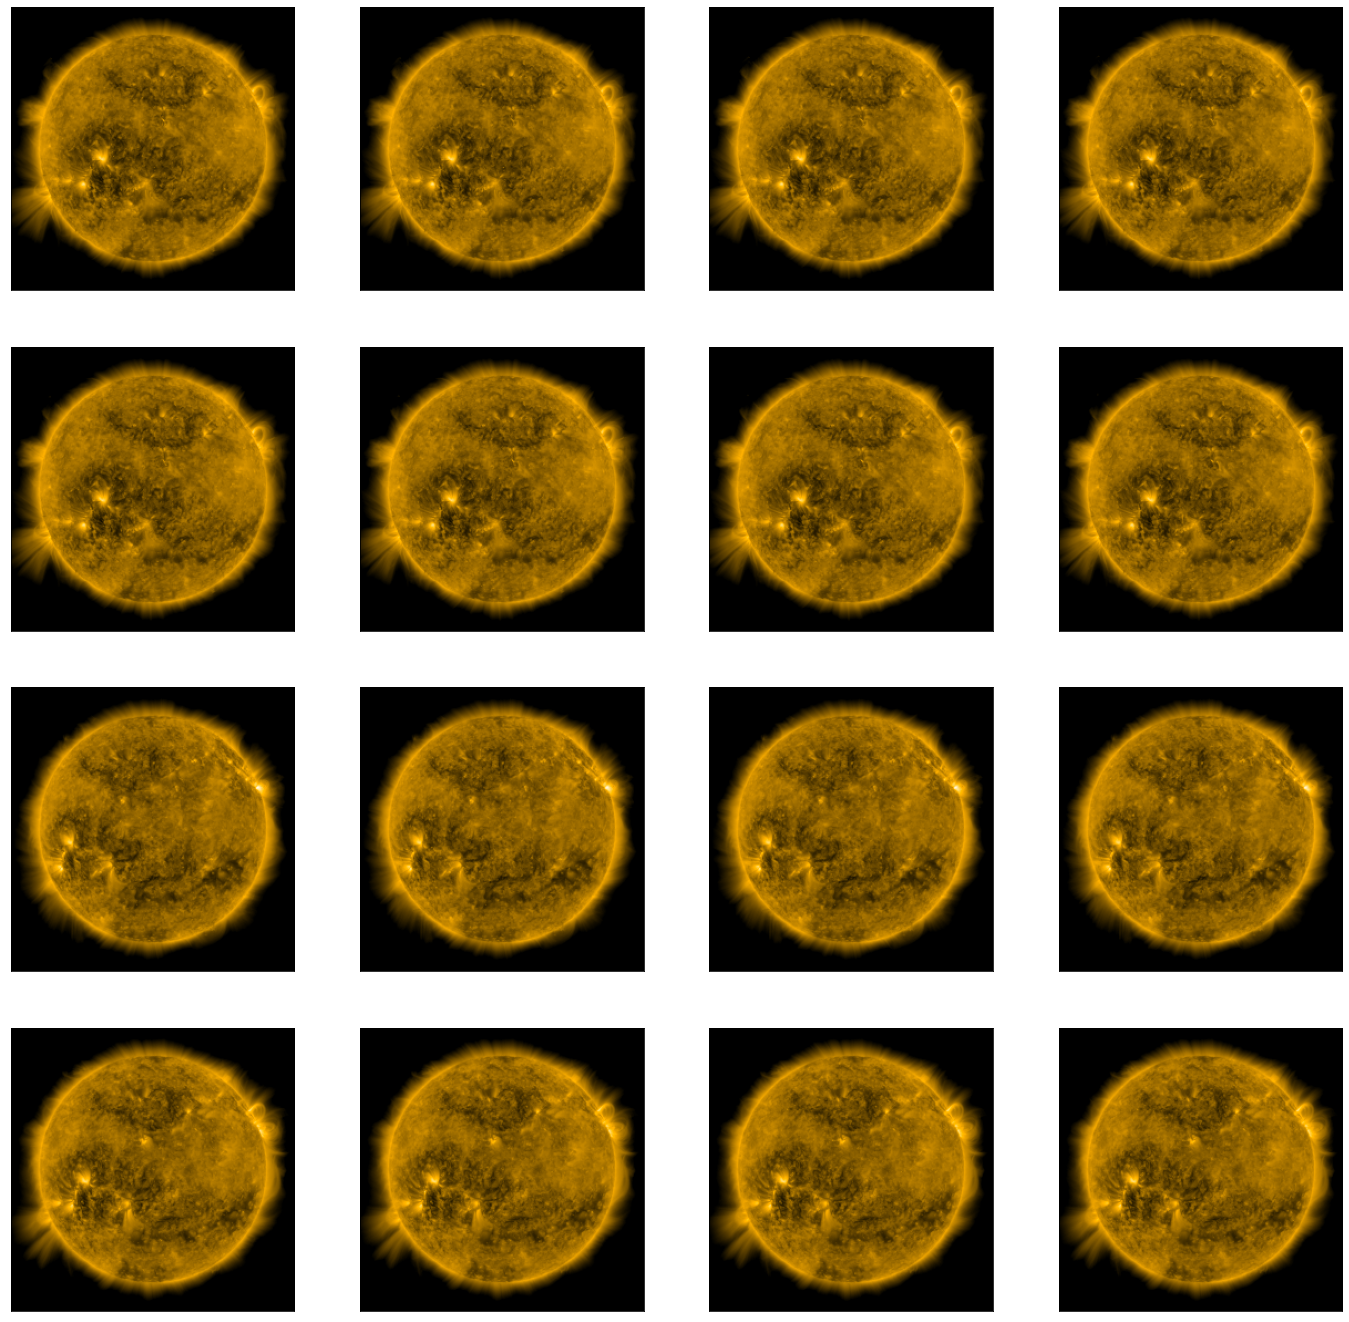

In [5]:
for batch_idx, samples in enumerate(loader):
    X, y = samples
    V = []
    for x in X:
        x = x.permute(1,2,0) # torch to pillow
        x = np.squeeze(x.numpy())
        v = vis(x, channel_to_map(171))
        V.append(Image.fromarray(v))
    show_grid(V)
    break

In [7]:
X[10].min()

tensor(-1.)

In [10]:
loader = SDOMLv2DataModule("fdl-sdoml-v2/sdomlv2_small.zarr/", channel="193A", train_start="2010-08-27 00:00:00", train_end="2010-08-28 23:59:59", test_start="2010-08-29 00:00:00", test_end="2010-08-29 23:59:59", train_val_split_temporal_chunk_size="1h", prefetch_factor=2, goes_cache_dir="../tmp/new", mask_limb=True, mask_limb_radius_scale_factor=0.9).train_dataloader()


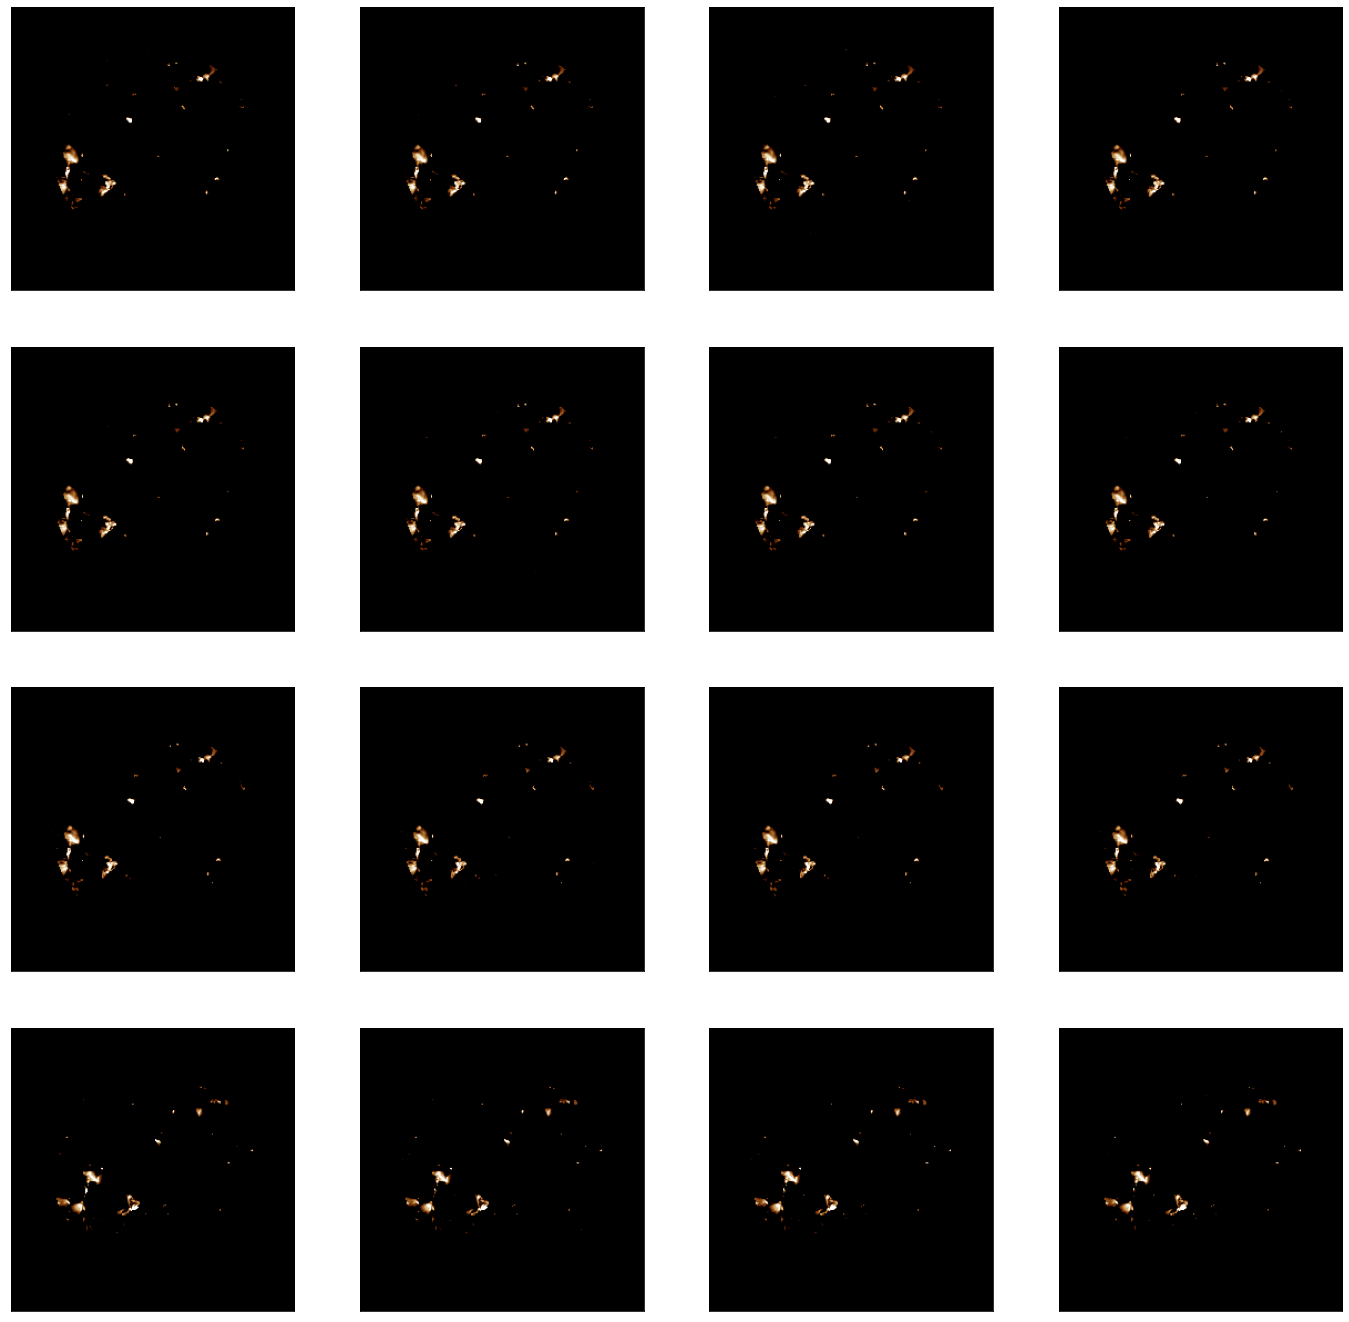

In [4]:
for batch_idx, samples in enumerate(loader):
    X, y = samples
    V = []
    for x in X:
        x = x.permute(1,2,0) # torch to pillow
        x = np.squeeze(x.numpy())
        v = vis(x, channel_to_map(193), get_clip(x, 193))
        V.append(Image.fromarray(v))
    show_grid(V)
    break

In [5]:
loader = SDOMLv2DataModule("fdl-sdoml-v2/sdomlv2_small.zarr/", channel="193A", train_start="2010-08-27 00:00:00", train_end="2010-08-28 23:59:59", test_start="2010-08-29 00:00:00", test_end="2010-08-29 23:59:59", train_val_split_temporal_chunk_size="1h", prefetch_factor=2, goes_cache_dir="../tmp/new").train_dataloader()


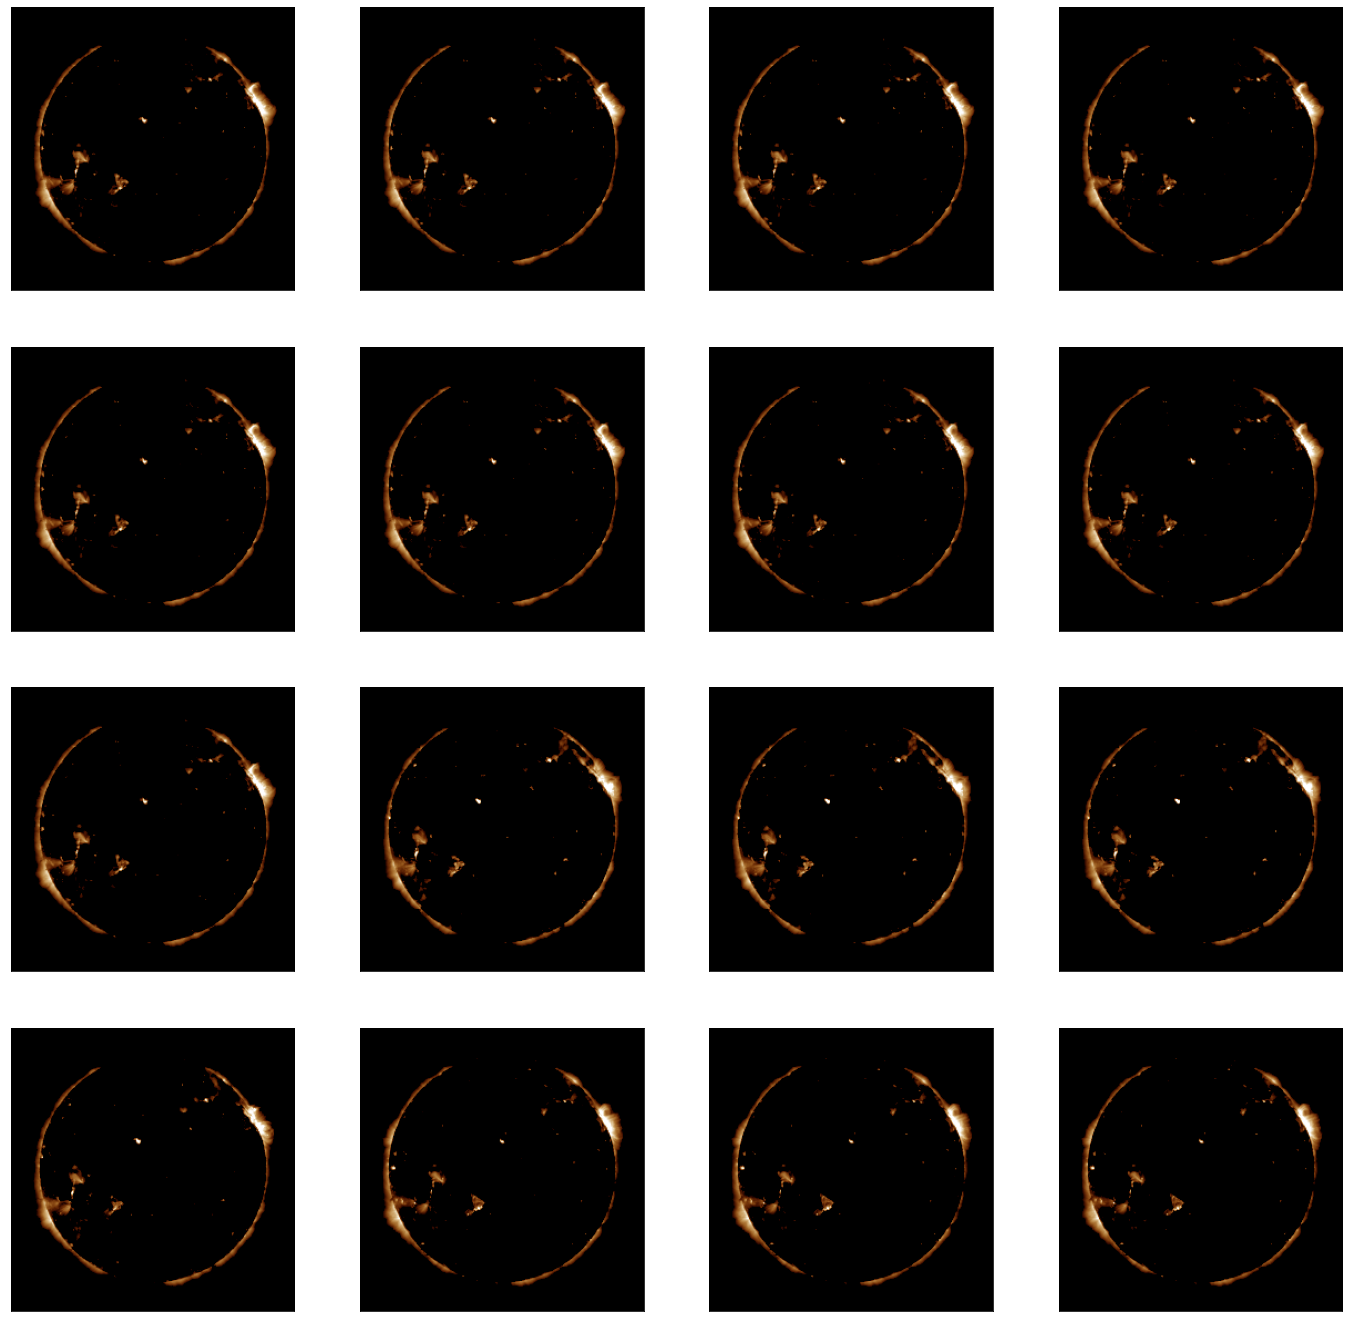

In [6]:
for batch_idx, samples in enumerate(loader):
    X, y = samples
    V = []
    for x in X:
        x = x.permute(1,2,0) # torch to pillow
        x = np.squeeze(x.numpy())
        v = vis(x, channel_to_map(193), get_clip(x, 171))
        V.append(Image.fromarray(v))
    show_grid(V)
    break

In [5]:
loader = SDOMLv2DataModule("fdl-sdoml-v2/sdomlv2_small.zarr/", channel="193A", train_start="2010-08-27 00:00:00", train_end="2010-08-28 23:59:59", test_start="2010-08-29 00:00:00", test_end="2010-08-29 23:59:59", train_val_split_temporal_chunk_size="1h", prefetch_factor=2, irradiance=1e-6, goes_cache_dir="../tmp/new").train_dataloader()


INFO:sdo.sood.data.sdo_ml_v2_dataset:found 477 images
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: https://storage.googleapis.com/download/storage/v1/b/fdl-sdoml-v2/o/sdomlv2_small.zarr%2F.zgroup?alt=media, (), {}
INFO:sdo.sood.data.sdo_ml_v2_dataset:discovered the following zarr directory structure
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',

In [ ]:
for batch_idx, samples in enumerate(loader):
    X, y = samples
    V = []
    for x in X:
        x = x.permute(1,2,0) # torch to pillow
        x = np.squeeze(x.numpy())
        v = vis(x, channel_to_map(193), get_clip(x, 171))
        V.append(Image.fromarray(v))
    show_grid(V)
    break

In [5]:
for key in y.keys():
    print("%s %s" % (key, y[key][0]))

ACS_CGT GT3
ACS_ECLP NO
ACS_MODE SCIENCE
ACS_SAFE NO
ACS_SUNP YES
AECDELAY tensor(1545)
AECMODE ON
AECTYPE tensor(0)
AGT1SVY tensor(0)
AGT1SVZ tensor(4)
AGT2SVY tensor(0)
AGT2SVZ tensor(-5)
AGT3SVY tensor(1)
AGT3SVZ tensor(0)
AGT4SVY tensor(2)
AGT4SVZ tensor(-3)
AIAECENF tensor(1)
AIAECTI tensor(0)
AIAGP1 tensor(0)
AIAGP10 tensor(748)
AIAGP2 tensor(0)
AIAGP3 tensor(0)
AIAGP4 tensor(0)
AIAGP5 tensor(0)
AIAGP6 tensor(0)
AIAGP7 tensor(0)
AIAGP8 tensor(280)
AIAGP9 tensor(344)
AIAHFSN tensor(10999686)
AIASEN tensor(6)
AIAWVLEN tensor(3)
AICFGDL1 tensor(0)
AICFGDL2 tensor(24)
AICFGDL3 tensor(88)
AICFGDL4 tensor(236)
AIFCPS tensor(55)
AIFDBID tensor(241)
AIFILTYP tensor(0)
AIFOENFL tensor(1)
AIFRMLID tensor(2908)
AIFTSID tensor(40962)
AIFTSWTH tensor(0)
AIFWEN tensor(270)
AIHIS192 tensor(0)
AIHIS348 tensor(0)
AIHIS604 tensor(0)
AIHIS860 tensor(0)
AIHISMXB tensor(0)
AIMGFSN tensor(2)
AIMGOTS tensor(1661612441)
AIMGOTSS tensor(45577)
AIMGSHCE tensor(2900)
AIMGSHEN tensor(4)
AIMGTYP tensor(0)
AI

In [12]:
obs_times = [
  '2010-08-27T06:48:08.07Z',
  '2010-08-27T06:54:08.07Z',
  '2010-08-27T08:00:08.07Z']
loader = SDOMLv2DataModule("fdl-sdoml-v2/sdomlv2_small.zarr/", channel="193A", train_start="2010-08-27 00:00:00", train_end="2010-08-28 23:59:59", test_start="2010-08-29 00:00:00", test_end="2010-08-29 23:59:59", train_val_split_temporal_chunk_size="1h", prefetch_factor=2, goes_cache_dir="../tmp/new", obs_times=obs_times, skip_test=True, sampling_strategy="default").train_dataloader()


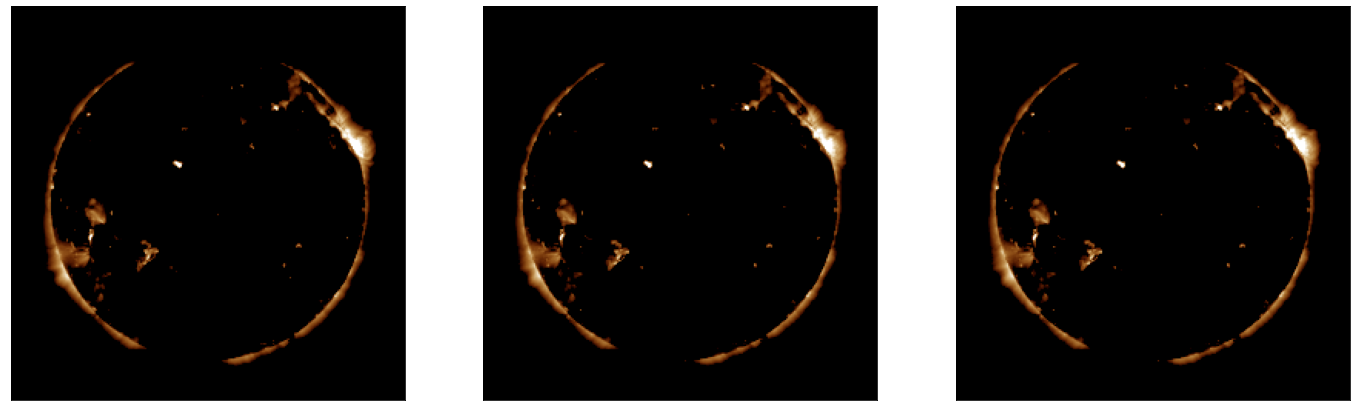

In [13]:
for batch_idx, samples in enumerate(loader):
    X, y = samples
    V = []
    for x in X:
        x = x.permute(1,2,0) # torch to pillow
        x = np.squeeze(x.numpy())
        v = vis(x, channel_to_map(193), get_clip(x, 171))
        V.append(Image.fromarray(v))
    show_grid(V)
    break

In [10]:
loader = SDOMLv2DataModule("fdl-sdoml-v2/sdomlv2_hmi_small.zarr/", channel="Bx", batch_size=16, prefetch_factor=2).train_dataloader()

DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: https://storage.googleapis.com/download/storage/v1/b/fdl-sdoml-v2/o/sdomlv2_hmi_small.zarr%2F.zgroup?

discovered the following zarr directory structure


DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: https://storage.googleapis.com/download/storage/v1/b/fdl-sdoml-v2/o/sdomlv2_hmi_small.zarr%2F2010%2F.zgroup?alt=media, (), {}
DEBUG:gcsfs:GET: b/{}/o,

/
 └── 2010
     ├── Bx (25540, 512, 512) float32
     ├── By (25540, 512, 512) float32
     └── Bz (25540, 512, 512) float32
found 25540 images


DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: https://storage.googleapis.com/download/storage/v1/b/fdl-sdoml-v2/o/sdomlv2_hmi_small.zarr%2F.zgroup?alt=media, (), {}
DEBUG:gcsfs:GET: b/{}/o, ('fdl-

discovered the following zarr directory structure


DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: https://storage.googleapis.com/download/storage/v1/b/fdl-sdoml-v2/o/sdomlv2_hmi_small.zarr%2F2010%2F.zgroup?alt=media, (), {}
DEBUG:gcsfs:GET: b/{}/o,

/
 └── 2010
     ├── Bx (25540, 512, 512) float32
     ├── By (25540, 512, 512) float32
     └── Bz (25540, 512, 512) float32
found 25540 images
Selecting groups for train-validation split. Number of groups 18, number of groups for training 13, number of groups for validation 5
splitting Dataset into two subsets. Train size 18714, validation size 6826


DEBUG:gcsfs:GET: https://storage.googleapis.com/download/storage/v1/b/fdl-sdoml-v2/o/sdomlv2_hmi_small.zarr%2F2010%2FBx%2F312.0.0?alt=media, (), {}
DEBUG:gcsfs:GET: https://storage.googleapis.com/download/storage/v1/b/fdl-sdoml-v2/o/sdomlv2_hmi_small.zarr%2F2010%2FBx%2F311.0.0?alt=media, (), {}


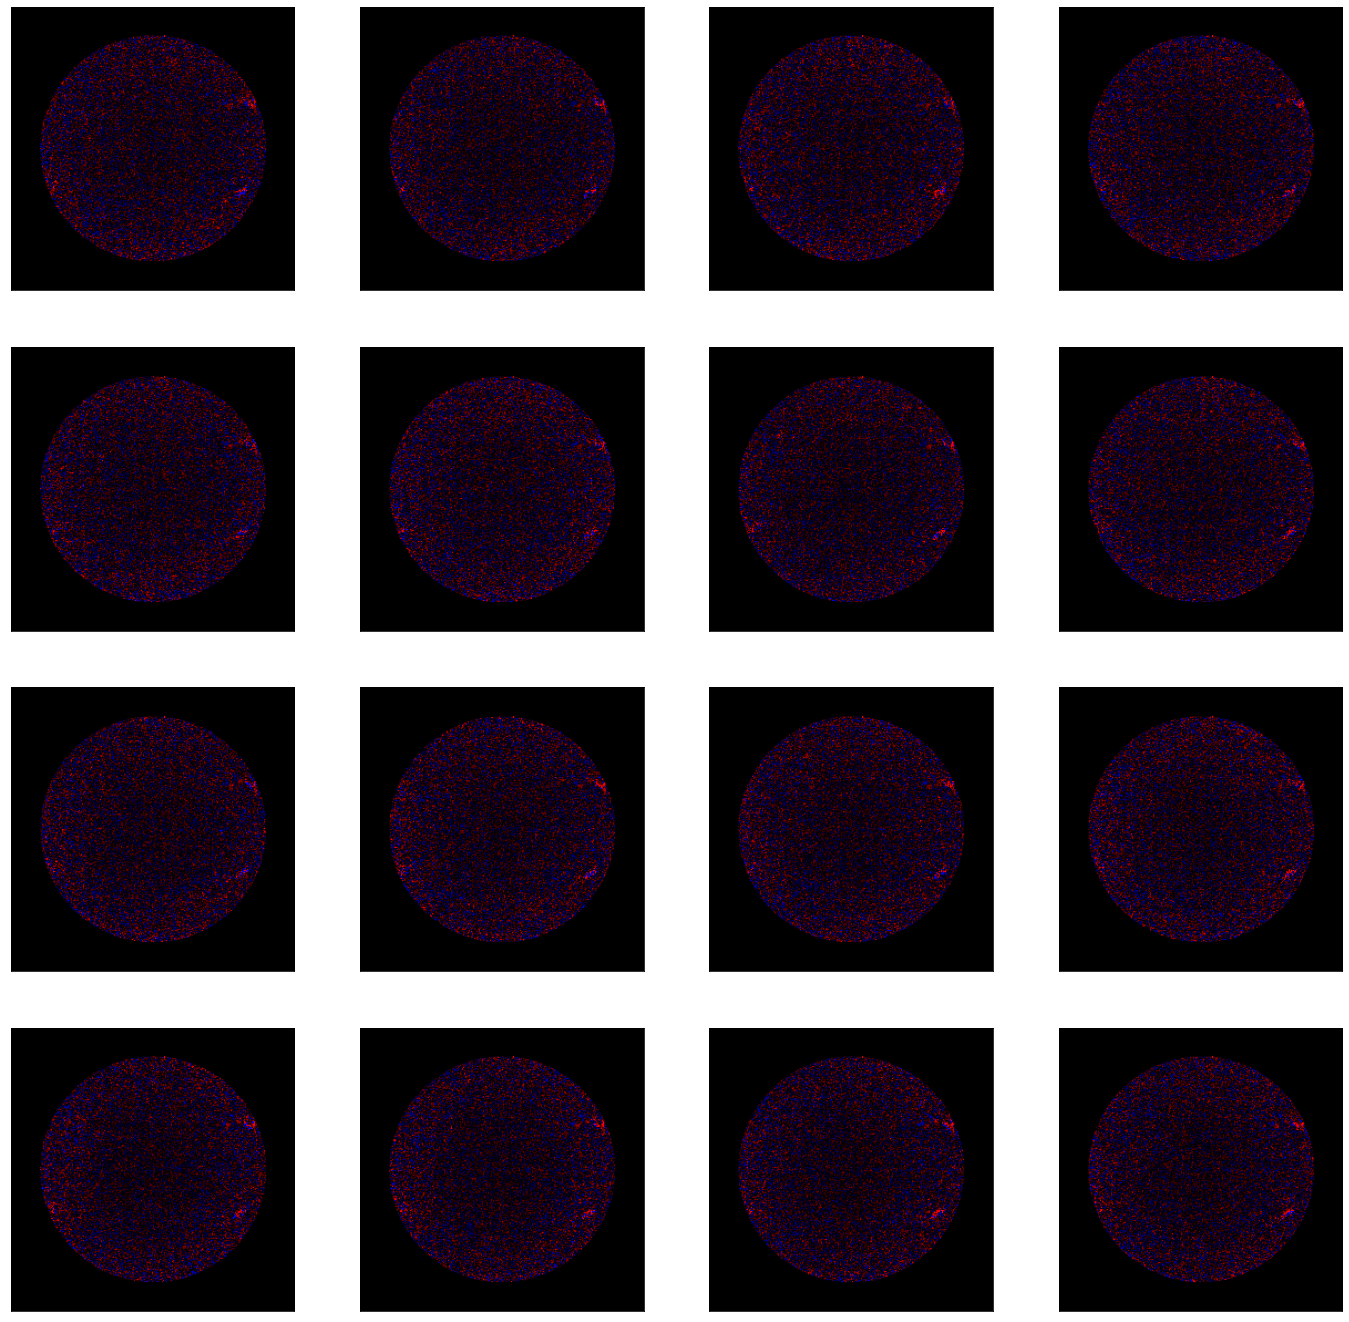

In [11]:
for batch_idx, samples in enumerate(loader):
    X, y = samples
    V = []
    for x in X:
        x = x.permute(1,2,0) # torch to pillow
        x = np.squeeze(x.numpy())
        v = vis(x, channel_to_map("Bx"), get_clip(x, "Bx"))
        V.append(Image.fromarray(v))
    show_grid(V)
    break

In [20]:
"""
Inspired by https://gist.github.com/wassname/8ae1f64389c2aaceeb84fcd34c3651c3

A Pytorch sampler that samples ordered indices from unordered sequences. 
Good for the use with Dask because Dask will slow down when sampling between chunks.
Usually, it is better if batches are uncorrelated so we want each batch to be sequence from a different part of a chunk.
For example, given each chunk is `range(12)`. Our seq_len is 3. We might end up with these indices:
- [[1,2,3],[9,10,11],[4,5,6]]
Usage:
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        sampler=SequenceInChunkSampler(train_dataset, seq_len=batch_size, chunksize=batch_size*100)
    )
"""
import torch.utils.data.sampler
import numpy as np


class SequenceInChunkSampler(torch.utils.data.sampler.Sampler):
    """
    Samples sequences of elements sequentially, but random sequences in a chunk.
    Arguments:
        data_source (Dataset): dataset to sample from
        seq_len (int): length of sequential sequences
        chunksize (int): length of cached data to take random sequences from
    """

    def __init__(self, data_source, seq_len=12, chunksize=120):
        assert chunksize % seq_len == 0, "chunk size should be a multiple of seq_len"
        assert len(data_source) > chunksize
        self.data_source = data_source
        self.seq_len = seq_len
        self.chunksize = chunksize

    def __iter__(self):
        chunk_idxs = np.arange(0, len(self.data_source), self.chunksize)
        max_i = len(self.data_source)
        np.random.shuffle(chunk_idxs)
        for chunk_idx in chunk_idxs:
            seqs = np.arange(
                chunk_idx, min(chunk_idx + self.chunksize, max_i), self.seq_len
            )
            np.random.shuffle(seqs)
            for seq_i in seqs:
                for i in np.arange(seq_i, min(seq_i + self.seq_len, max_i)):
                    yield i

    def __len__(self):
        return len(self.data_source)


In [26]:
sampler = SequenceInChunkSampler(range(512), seq_len=12, chunksize=120)

In [27]:
for i in enumerate(sampler):
    print(i[1])

180
181
182
183
184
185
186
187
188
189
190
191
156
157
158
159
160
161
162
163
164
165
166
167
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
144
145
146
147
148
149
150
151
152
153
154
155
204
205
206
207
208
209
210
211
212
213
214
215
120
121
122
123
124
125
126
127
128
129
130
131
168
169
170
171
172
173
174
175
176
177
178
179
192
193
194
195
196
197
198
199
200
201
202
203
132
133
134
135
136
137
138
139
140
141
142
143
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
36
37
38
39
40
41
42
43
44
45
46
47
24
25
26
27
28
29
30
31
32
33
34
35
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
264
265
266
267
268
269
270
271
272
273
274
275
240
241
242
243
244
245
246
247
248
249
250
251
324
325
326
327
328
329
330
331
332
333
334
335
300
30

In [19]:
chunk_idxs = np.arange(0, len(range(512)), 120)
chunk_idxs

array([  0, 120, 240, 360, 480])